### Задача

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Для коррекции рекламного бюджета нужно узнать, какой тариф приносит больше денег.  
Есть небольшая выборка клиентов - данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Оглавление

[1. Открытие и изучение данных](#1.-Открытие-и-изучение-данных)  
[2. Подготовка данных](#2.-Подготовка-данных)  
&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Поиск ошибок](#2.1-Поиск-ошибок)  
&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Изменение типов данных](#2.2-Изменение-типов-данных)  
&nbsp;&nbsp;&nbsp;&nbsp;[2.3 Проверка наличия дубликатов](#2.3-Проверка-наличия-дубликатов)  
&nbsp;&nbsp;&nbsp;&nbsp;[2.4 Расчёты](#2.4-Расчёты)  
[3. Анализ данных](#3.-Анализ-данных)  
[4. Проверка гипотез](#4.-Проверка-гипотез)  
&nbsp;&nbsp;&nbsp;&nbsp;[4.1 Cредняя выручка пользователей тарифов smart и ultra различается](#4.1-Cредняя-выручка-пользователей-тарифов-smart-и-ultra-различается)  
&nbsp;&nbsp;&nbsp;&nbsp;[4.2 Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов](#4.2-Средняя-выручка-пользователей-из-Москвы-отличается-от-выручки-пользователей-из-других-регионов)  
[5. Общий вывод](#5.-Общий-вывод)

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from math import factorial
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Открытие и изучение данных 

In [2]:
df_calls = pd.read_csv('/datasets/calls.csv')
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [3]:
df_internet = pd.read_csv('/datasets/internet.csv')
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [4]:
df_messages = pd.read_csv('/datasets/messages.csv')
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [5]:
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [6]:
df_users = pd.read_csv('/datasets/users.csv')
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


### Вывод

Есть 5 таблиц. 3 связаны с таблицей `df_users` через `user_id`. И 1 с общей информацией про тарифы, связанная с `df_users` через `tariff_name`.  
Пропущенные значения есть только в колонке `churn_date` таблицы `df_users`.  
Колонки с датами имеют тип `object`.  
Колонка `duration` таблицы `df_calls` и колонка `mb_used` таблицы `df_internet` имеют тип `float64`.  
В таблице `df_internet` есть колонка без названия `Unnamed: 0`. 

### 2. Подготовка данных

#### 2.1 Поиск ошибок 

In [7]:
df_internet.sample(10)

,Unnamed: 0,id,mb_used,session_date,user_id
86461,86461,1292_577,269.98,2018-08-09,1292
94123,94123,1318_137,460.90,2018-11-11,1318
110893,110893,1376_153,394.53,2018-08-18,1376
132634,132634,1441_22,683.22,2018-11-17,1441
128177,128177,1429_335,0.00,2018-10-03,1429
44540,44540,1154_98,784.72,2018-07-11,1154
144909,144909,1483_288,1130.30,2018-04-13,1483
51999,51999,1176_154,722.12,2018-05-10,1176
140394,140394,1472_68,594.73,2018-05-03,1472
111502,111502,1378_295,569.90,2018-10-10,1378


Колонка `Unnamed: 0` дублирует индексы, две одинаковые колонки не нужны, удаляем.

In [8]:
df_internet.drop('Unnamed: 0', axis=1, inplace=True)
df_internet.columns

Index(['id', 'mb_used', 'session_date', 'user_id'], dtype='object')

Проверим минимальные и максимальные значения в колонках с количественными переменными.

In [9]:
def col_inf(data): 
    for el in data.select_dtypes(['int64', 'float64']).columns:
        print(el, data[el].min(), data[el].max(), sep='\n')

In [10]:
col_inf(df_users)

user_id
1000
1499
age
18
75


In [11]:
col_inf(df_calls)

duration
0.0
38.0
user_id
1000
1499


In [12]:
col_inf(df_internet)

mb_used
0.0
1724.83
user_id
1000
1499


In [13]:
col_inf(df_messages)

user_id
1000
1499


Диапазон `user_id` совпадает.  
Возраст, длительность звонков и объем интернет-трафика корректны.  
В колонках `mb_used` и `duration` есть значения 0. Найдем их количество.

In [14]:
null_values = pd.DataFrame({
    'total':[len(df_calls),len(df_internet)], 
    'null_values':[len(df_calls.query('duration == 0')), len(df_internet.query('mb_used == 0'))]
}, index=['calls','internet'])
null_values['percent_of_null_values'] = null_values['null_values'] / null_values['total']
null_values['percent_of_null_values'] = null_values['percent_of_null_values'].mul(100).round(2).astype(str).add('%')
null_values

,total,null_values,percent_of_null_values
calls,202607,39613,19.55%
internet,149396,19598,13.12%


Согласно постановлению Правительства РФ от 09.12.2014 N 1342 (ред. от 27.05.2019) "О порядке оказания услуг телефонной связи" (вместе с "Правилами оказания услуг телефонной связи")  
"Продолжительность телефонного соединения, используемая для определения размера платы за соединение, отсчитывается с 1-й секунды после ответа вызываемого оборудования до момента отбоя вызывающего или вызываемого оборудования или оборудования, заменяющего пользователя в его отсутствие. Телефонное соединение продолжительностью менее 3 секунд не учитывается в объеме оказанных услуг телефонной связи."  
Поэтому учитывать нулевые значения мы не можем.  
В задании сказано, что с 1 секунды засчитывается целая минута. Будем считать, что условие такое в силу того, что проект учебный. 

#### 2.2 Изменение типов данных

Округлим значения и изменим тип данных с типа `float64` на `int64` в колонке `duration` таблицы `df_calls` и в колонке `mb_used` таблицы `df_internet`. Если длительность разговора составила, например, 1,01 мин, то засчитывается 2 мин, округляем до большего.

In [15]:
print(df_calls['duration'].head(5))
df_calls['duration'] = df_calls['duration'].apply(np.ceil).astype(int)
df_calls['duration'].head(5)

0     0.00
1     0.00
2     2.85
3    13.80
4     5.18
Name: duration, dtype: float64


0     0
1     0
2     3
3    14
4     6
Name: duration, dtype: int64

In [16]:
print(df_internet['mb_used'].head(5))
df_internet['mb_used'] = df_internet['mb_used'].apply(np.ceil).astype(int)
df_internet['mb_used'].head(5)

0     112.95
1    1052.81
2    1197.26
3     550.27
4     302.56
Name: mb_used, dtype: float64


0     113
1    1053
2    1198
3     551
4     303
Name: mb_used, dtype: int64

Все даты приведем к формату `datetime64`

In [17]:
def to_date(data, col):
    data[col] = pd.to_datetime(data[col])
    print(data[col].dtype)

In [18]:
to_date(df_calls, 'call_date')
to_date(df_internet, 'session_date')
to_date(df_messages, 'message_date')
to_date(df_users, 'reg_date')
to_date(df_users, 'churn_date')

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


#### 2.3 Проверка наличия дубликатов

In [19]:
df_users.duplicated().sum()

0

#### 2.4 Расчёты

Посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам.

In [20]:
#создаем таблицу с данными о пользователях и их звонках
df_calls['month'] = df_calls['call_date'].dt.month
users_calls = df_users.merge(df_calls, on='user_id', how='left') 
users_calls.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,call_date,duration,month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-07-25,0.0,7.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-08-17,0.0,8.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-06-11,3.0,6.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-09-21,14.0,9.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-15,6.0,12.0


In [21]:
users_calls[users_calls['duration'].isna()]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,call_date,duration,month
36344,1091,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra,NaN,NaT,NaN,NaN
42758,1106,67,NaT,Калуга,Исаак,Костин,2018-04-26,ultra,NaN,NaT,NaN,NaN
51654,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,NaN,NaT,NaN,NaN
92592,1231,63,NaT,Чебоксары,Касьян,Авдюков,2018-05-23,ultra,NaN,NaT,NaN,NaN
127924,1328,44,NaT,Мурманск,Рауль,Аркадьев,2018-10-16,ultra,NaN,NaT,NaN,NaN
145827,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,NaN,NaT,NaN,NaN
193093,1473,18,NaT,Красноярск,Николай,Лебедев,2018-08-05,ultra,NaN,NaT,NaN,NaN
198661,1489,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,NaN,NaT,NaN,NaN


8 человек оформили тариф, но звонков не совершали.  
6 из них скорее всего пользовались другими услугами.  
А 2 через неделю отключили тариф, их считать не будем.  
В итоговой таблице будем ориентироваться на 498 пользователей (без 145827 и 51654).

Создаем сводную таблицу с количеством сделанных звонков и потраченных минут.

In [22]:
def total_pivot_table(data, col, val, func):
    pt = data.pivot_table(
        index=[data[col], 'user_id', 'tariff', 'city'], 
        values= val,
        aggfunc= func
    ).reset_index()
    return pt

In [23]:
users_calls_report = total_pivot_table(users_calls, 'month', 'duration', ['count', 'sum'])
users_calls_report.columns = ['month', 'user_id', 'tariff', 'city', 'count_calls', 'sum_minutes']
users_calls_report

,month,user_id,tariff,city,count_calls,sum_minutes
0,1.0,1005,smart,Набережные Челны,15,95.0
1,1.0,1032,smart,Ульяновск,61,380.0
2,1.0,1045,smart,Улан-Удэ,1,9.0
3,1.0,1055,smart,Казань,64,551.0
4,1.0,1071,smart,Омск,24,194.0
...,...,...,...,...,...,...
3169,12.0,1494,smart,Омск,62,418.0
3170,12.0,1495,ultra,Иркутск,155,1031.0
3171,12.0,1496,smart,Вологда,80,518.0
3172,12.0,1497,smart,Челябинск,71,545.0


Посчитаем количество отправленных сообщений по месяцам.

In [24]:
#создаем таблицу с данными о пользователях и их сообщениях
df_messages['month'] = df_messages['message_date'].dt.month
users_messages = df_users.merge(df_messages, on='user_id', how='left')
users_messages.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,message_date,month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-06-27,6.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-10-08,10.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-08-04,8.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-06-16,6.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-05,12.0


Создаем сводную таблицу с количеством отправленных сообщений по месяцам.

In [25]:
users_messages_report = total_pivot_table(users_messages, 'month', 'id', 'count')
users_messages_report.columns = ['month', 'user_id', 'tariff', 'city', 'count_messages']
users_messages_report

,month,user_id,tariff,city,count_messages
0,1.0,1005,smart,Набережные Челны,7
1,1.0,1032,smart,Ульяновск,38
2,1.0,1045,smart,Улан-Удэ,5
3,1.0,1055,smart,Казань,30
4,1.0,1071,smart,Омск,16
...,...,...,...,...,...
2712,12.0,1493,ultra,Красноярск,78
2713,12.0,1495,ultra,Иркутск,84
2714,12.0,1496,smart,Вологда,51
2715,12.0,1497,smart,Челябинск,17


Посчитаем объем израсходованного интернет-трафика по месяцам.

In [26]:
#создаем таблицу с данными о пользователях и их интернет-сессиях
df_internet['month'] = df_internet['session_date'].dt.month
users_internet = df_users.merge(df_internet, on='user_id', how='left')
users_internet.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,mb_used,session_date,month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,113.0,2018-11-25,11.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,1053.0,2018-09-07,9.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,1198.0,2018-06-25,6.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,551.0,2018-08-22,8.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,303.0,2018-09-24,9.0


Создаем сводную таблицу с объемом израсходованного интернет-трафика по месяцам.

In [27]:
users_internet_report = total_pivot_table(users_internet, 'month', 'mb_used', 'sum')
users_internet_report.columns = ['month', 'user_id', 'tariff', 'city', 'sum_mb_used']
print('Всего пользователей:',len(users_internet_report.groupby('user_id')))
users_internet_report

Всего пользователей: 497


,month,user_id,tariff,city,sum_mb_used
0,1.0,1005,smart,Набережные Челны,2730.0
1,1.0,1032,smart,Ульяновск,24147.0
2,1.0,1045,smart,Улан-Удэ,2348.0
3,1.0,1055,smart,Казань,17111.0
4,1.0,1071,smart,Омск,15622.0
...,...,...,...,...,...
3198,12.0,1494,smart,Омск,17645.0
3199,12.0,1495,ultra,Иркутск,23450.0
3200,12.0,1496,smart,Вологда,20757.0
3201,12.0,1497,smart,Челябинск,19940.0


Создадим итоговую таблицу.

In [28]:
total_users = (users_calls_report
               .merge(users_messages_report, how='outer', on=['user_id', 'month','tariff', 'city'])
               .merge(users_internet_report, how='outer', on=['user_id', 'month', 'tariff', 'city']))
print('Всего пользователей:',len(total_users.groupby('user_id')))
total_users.fillna(0, inplace=True)
total_users

Всего пользователей: 498


,month,user_id,tariff,city,count_calls,sum_minutes,count_messages,sum_mb_used
0,1.0,1005,smart,Набережные Челны,15.0,95.0,7.0,2730.0
1,1.0,1032,smart,Ульяновск,61.0,380.0,38.0,24147.0
2,1.0,1045,smart,Улан-Удэ,1.0,9.0,5.0,2348.0
3,1.0,1055,smart,Казань,64.0,551.0,30.0,17111.0
4,1.0,1071,smart,Омск,24.0,194.0,16.0,15622.0
...,...,...,...,...,...,...,...,...
3209,12.0,1231,ultra,Чебоксары,0.0,0.0,191.0,32481.0
3210,12.0,1328,ultra,Мурманск,0.0,0.0,7.0,39461.0
3211,12.0,1473,ultra,Красноярск,0.0,0.0,20.0,18432.0
3212,12.0,1489,smart,Санкт-Петербург,0.0,0.0,35.0,17341.0


Проверим, те ли пользователи, не попали в итоговую таблицу. 

In [29]:
len(users_internet_report.query('user_id == 145827 & user_id == 51654')) 

0

Все верно, эти пользователи не пользовались тарифом и отключили его через неделю. Значит их считать не будем.

Посчитаем помесячную выручку с каждого пользователя и оформим все результаты в одной таблице.

In [30]:
total_users['revenue'] = np.nan
# для каждого тарифа посчитаем помесячную выручку с каждого пользователя
for tariff in df_tariffs['tariff_name'].values:
    total_users_tariff = total_users[total_users['tariff'] == tariff]
    ind = df_tariffs[df_tariffs['tariff_name'] == tariff].index
        
    revenue_calls = (total_users_tariff['sum_minutes'] - df_tariffs.loc[ind,'minutes_included'].values) * df_tariffs.loc[ind,'rub_per_minute'].values
    # если пользователь потратил меньше минут, чем было доступно, то оставшиеся минуты пропадают
    revenue_calls[revenue_calls < 0] = 0
    
    revenue_messages = (total_users_tariff['count_messages'] - df_tariffs.loc[ind,'messages_included'].values) * df_tariffs.loc[ind,'rub_per_message'].values
    revenue_messages[revenue_messages < 0] = 0
    
    revenue_internet = (total_users_tariff['sum_mb_used'] - df_tariffs.loc[ind,'mb_per_month_included'].values) / 1024 * df_tariffs.loc[ind,'rub_per_gb'].values
    revenue_internet[revenue_internet < 0] = 0
    
    total_users['revenue'] = (total_users['revenue'].fillna(
        revenue_calls + revenue_messages + revenue_internet + df_tariffs.loc[ind,'rub_monthly_fee'].values
    )).round(2)

print('Всего пользователей:',len(total_users.groupby('user_id')))    
total_users

Всего пользователей: 498


,month,user_id,tariff,city,count_calls,sum_minutes,count_messages,sum_mb_used,revenue
0,1.0,1005,smart,Набережные Челны,15.0,95.0,7.0,2730.0,550.00
1,1.0,1032,smart,Ульяновск,61.0,380.0,38.0,24147.0,2266.21
2,1.0,1045,smart,Улан-Удэ,1.0,9.0,5.0,2348.0,550.00
3,1.0,1055,smart,Казань,64.0,551.0,30.0,17111.0,1044.99
4,1.0,1071,smart,Омск,24.0,194.0,16.0,15622.0,601.17
...,...,...,...,...,...,...,...,...,...
3209,12.0,1231,ultra,Чебоксары,0.0,0.0,191.0,32481.0,2207.96
3210,12.0,1328,ultra,Мурманск,0.0,0.0,7.0,39461.0,3230.42
3211,12.0,1473,ultra,Красноярск,0.0,0.0,20.0,18432.0,1950.00
3212,12.0,1489,smart,Санкт-Петербург,0.0,0.0,35.0,17341.0,936.91


### Вывод

Округлили значения и изменили тип данных с типа float64 на int64 в колонке duration таблицы df_calls и в колонке mb_used таблицы df_internet. Нулевые значения оставили так как оплата за услугу начинается с 1 сек.  
Все даты привели к формату `datetime64`.  
Расчитали: количество сделанных звонков и израсходованных минут разговора по месяцам, количество отправленных сообщений по месяцам, объем израсходованного интернет-трафика по месяцам, помесячную выручку с каждого пользователя.
В итоговой таблице оставили 498 пользователей, так как 2 пользователя не использовали тариф и отключили его через неделю. 

### 3. Анализ данных

Посмотрим сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.

In [31]:
table_tariffs = total_users.pivot_table( index=['tariff', 'month'], 
                        values=['count_calls', 'sum_minutes', 'count_messages', 'sum_mb_used', 'revenue'],
                        aggfunc='median'
                       ).round(2)
table_tariffs['count_users'] = total_users.groupby(['tariff','month'])['user_id'].count()
table_tariffs

count_calls  count_messages  revenue  sum_mb_used  sum_minutes  \
tariff month                                                                   
smart  1.0           20.5            15.0   550.00       7107.0        162.5   
       2.0           38.5            20.0   550.00      12572.5        258.0   
       3.0           59.0            23.0   876.84      15690.0        409.0   
       4.0           52.0            28.0   587.50      14104.5        368.5   
       5.0           59.0            30.0   935.94      16343.0        433.0   
       6.0           59.0            28.0   884.04      16095.5        400.0   
       7.0           58.0            29.0   913.67      15948.0        414.0   
       8.0           62.0            27.0   972.07      16855.0        432.0   
       9.0           61.0            30.0   932.32      16050.0        435.0   
       10.0          60.5            30.0  1058.94      17248.5        427.5   
       11.0          60.0            28.0  1099.22      17036.5        428.5   
       12.0          65.0            29.0  1191.02      17741.0        471.0   
ultra  1.0           51.0            32.0  1950.00      14808.0        382.0   
       2.0           25.0             5.5  1950.00       7335.5        168.0   
       3.0           57.0            20.0  1950.00      17513.0        403.0   
       4.0           61.0            17.0  1950.00      16662.0        453.0   
       5.0           75.0            25.0  1950.00      18717.0        519.0   
       6.0           68.0            27.5  1950.00      19495.5        479.0   
       7.0           77.0            38.0  1950.00      20034.0        542.0   
       8.0           73.0            40.0  1950.00      18945.0        500.0   
       9.0           74.0            43.0  1950.00      19675.0        520.0   
       10.0          75.0            49.0  1950.00      20359.0        533.0   
       11.0          77.0            43.0  1950.00      18398.0        546.0   
       12.0          82.0            51.0  1950.00      21994.0        584.0   

              count_users  
tariff month               
smart  1.0             34  
       2.0             58  
       3.0             77  
       4.0            112  
       5.0            141  
       6.0            164  
       7.0            201  
       8.0            235  
       9.0            260  
       10.0           294  
       11.0           316  
       12.0           337  
ultra  1.0              9  
       2.0             24  
       3.0             37  
       4.0             55  
       5.0             67  
       6.0             84  
       7.0             91  
       8.0            107  
       9.0            115  
       10.0           123  
       11.0           134  
       12.0           139

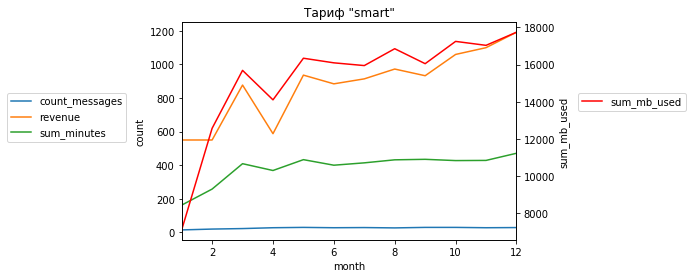

In [32]:
ax1 = table_tariffs.loc['smart'].loc[:,['count_messages','revenue','sum_minutes']].plot(title='Тариф "smart"')
ax1.set_ylabel('count')
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
ax1.legend(bbox_to_anchor=(-0.15, 0.7))
table_tariffs.loc['smart']['sum_mb_used'].plot(ax=ax2, style='r').set_ylabel('sum_mb_used')
ax2.legend(bbox_to_anchor=(1.52, 0.7))

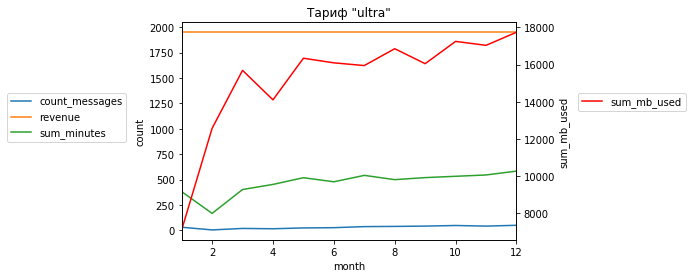

In [33]:
ax1 = table_tariffs.loc['ultra'].loc[:,['count_messages','revenue','sum_minutes']].plot(title='Тариф "ultra"')
ax1.set_ylabel('count')
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
ax1.legend(bbox_to_anchor=(-0.15, 0.7))
table_tariffs.loc['smart']['sum_mb_used'].plot(ax=ax2, style='r').set_ylabel('sum_mb_used')
ax2.legend(bbox_to_anchor=(1.52, 0.7))

Тариф `smart` привлекает больше людей, чем `ultra`, это и понятно, цена за месяц услуг меньше в 3,5 раза.  
При этом пользователям чаще всего не хватает стандартного пакета. В среднем, лишь 2 месяца  принесли стандартную стоимость. В остальных месяцах пользователи доплачивали сверх пакета.  
Тариф `ultra` для большинства пользователей включает достаточный пакет, поэтому доплаты не требуется.  
На обоих тарифах в течение года подключаются новые абоненты, медианные значения количественных метрик тоже растут.

In [34]:
total_users[total_users['tariff'] == 'smart'].describe().round(2)

,month,user_id,count_calls,sum_minutes,count_messages,sum_mb_used,revenue
count,2229.00,2229.00,2229.00,2229.00,2229.00,2229.00,2229.00
mean,8.35,1246.51,58.46,417.93,33.38,16229.19,1233.35
std,2.92,146.12,25.94,190.31,28.23,5877.58,787.69
min,1.00,1001.00,0.00,0.00,0.00,0.00,550.00
25%,6.00,1121.00,40.00,282.00,10.00,12658.00,550.00
50%,9.00,1239.00,60.00,422.00,28.00,16531.00,959.90
75%,11.00,1376.00,76.00,545.00,51.00,20068.00,1668.12
max,12.00,1499.00,198.00,1435.00,143.00,38610.00,6711.02


Если рассмотреть в целом по году, то при тарифе `smart` пользователям, в среднем, не хватает объема интернет-трафика. 50% пользователей вместо 15360 Мб используют до 16531 Мб и поэтому платят больше - 960р.  
Разница медианного значения и среднего в 273р показывает, что многие пользователи не укладываются даже в 960р и платят цену примерно в 2 раза больше стандартной и больше.

In [35]:
total_users[total_users['tariff'] == 'ultra'].describe().round(2)

,month,user_id,count_calls,sum_minutes,count_messages,sum_mb_used,revenue
count,985.00,985.00,985.00,985.00,985.00,985.00,985.00
mean,8.25,1263.09,73.39,526.62,49.36,19486.90,2060.53
std,2.87,140.69,43.92,317.61,47.80,10096.32,356.31
min,1.00,1000.00,0.00,0.00,0.00,0.00,1950.00
25%,6.00,1143.00,41.00,284.00,6.00,11785.00,1950.00
50%,9.00,1277.00,74.00,518.00,38.00,19324.00,1950.00
75%,11.00,1381.00,104.00,752.00,79.00,26863.00,1950.00
max,12.00,1495.00,244.00,1673.00,224.00,49789.00,4743.31


Не все пользователи тарифа `ultra` укладываются в стандартный пакет, но их мало. По среднему значению видно влияние выбросов, оно как раз отличается от медианного в большую сторону, но всего на 110р. 

Посчитаем медиану, чтобы исключить влияние выбросов, дисперсию и стандартное отклонение выручки для каждого тарифа. 

In [36]:
def metric(tariff):

    m_revenue_tariff = total_users[total_users['tariff'] == tariff]['revenue']
    variance_tariff = np.var(m_revenue_tariff.values,ddof=1).round(2)
    st_dev_tariff = np.sqrt(variance_tariff).round(2)
    median_tariff = m_revenue_tariff.median()
    return variance_tariff, st_dev_tariff, median_tariff
    
metrics_smart = metric('smart')
metrics_ultra = metric('ultra')
metrics = pd.DataFrame({'tariff': ['smart', 'ultra'],
                        'variance': [metrics_smart[0], metrics_ultra[0]],
                        'standart_deviation': [metrics_smart[1], metrics_ultra[1]],
                        'median': [metrics_smart[2], metrics_ultra[2]]
                       })
metrics

,tariff,variance,standart_deviation,median
0,smart,620452.58,787.69,959.9
1,ultra,126953.29,356.31,1950.0


Видно, что средняя выручка тарифа `ultra` в 2 раза больше, чем средняя выручка тарифа `smart`.  
При этом вариативность дисперсии и стандартного отклонения существенно ниже в тарифе `ultra`. В тарифе `smart` менее стабильные пользователи.

Посмотрим на гистограммы количественных переменных.

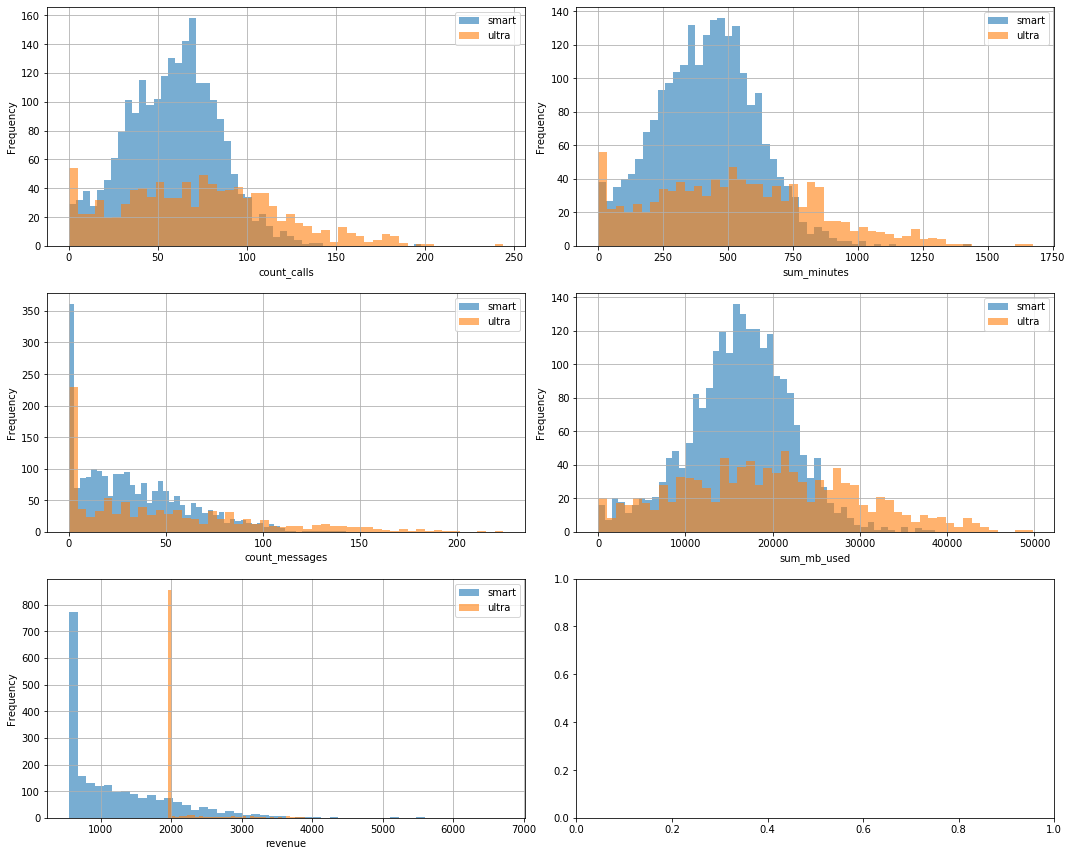

In [37]:
fig, axes = plt.subplots(3,2, figsize=(15,12))  
columns = ['count_calls', 'sum_minutes', 'count_messages','sum_mb_used', 'revenue']
for ind, col in enumerate(columns):
    total_users[total_users['tariff'] == 'smart'][col].plot(
        kind='hist',grid=True, alpha=0.6, bins=50, ax=axes[ind // 2][ind % 2], label='smart', legend=True
    ).set_xlabel(col)
    
    total_users[total_users['tariff'] == 'ultra'][col].plot(
       kind='hist',grid=True, alpha=0.6, bins=50, ax=axes[ind // 2][ind % 2], label='ultra', legend=True
   ).set_xlabel(col)
    
plt.tight_layout()
plt.show()

Все распределения ограничены 0, отрицательных значений быть не может. Так, распределения Пуассона на гистограммах `count_calls`, `sum_minutes`, `sum_mb_used` выглядят более равномерно и смещаются в обе стороны, напоминают нормальное, но имеют ограничения слева.  
А распределения Пуассона `count_messages` и `revenue` больше смещены вправо.

Тариф `ultra`  

На гистограммах видно, что разброс основных показателей из тарифного пакета `ultra` больше. Это происходит в силу доступности большего объема пакета. Гистограммы более плоские. Разброс с выручкой практически отсутствует. Выделяются нулевые значения на гистаграммах `count_calls`, `sum_minutes`, `count_messages`, при этом на гистограмме `sum_mb_used` наблюдается пик у 20000 Мб и нулевые значения особо не выделяются. Вероятно, некоторые пользователи оформляют тариф по больше части для использования интернет-трафика.  

Тариф `smart`  

Здесь популярностью пользуются больше звонки и интернет, на этих гистограммах видны явные пики: `sum_minutes` - 500 мин (как раз максимальное количество из стандартного пакета), `sum_mb_used` - 16000 Мб (превышают стандартный пакет). Многие люди не используют сообщения совсем. Чаще всего пользователи платят 550 р, но многие не укладываются в стандартный пакет и платят больше.

Рассчитаем сколько выручки приносят пользователи

In [38]:
report_tariffs = total_users.pivot_table( index=['tariff'], 
                        values=['revenue'],
                        aggfunc='sum'
                       ).round(2)
report_tariffs['count_users'] = df_users['tariff'].value_counts().values
report_tariffs

,revenue,count_users
tariff,,
smart,2749135.84,351
ultra,2029622.05,149


На тариф `smart` 351 пользователь, на 135% больше, чем на тарифе `ultra`. Но при этом суммарные доходы от `smart` привышают доходы от `ultra` только на 35%. 

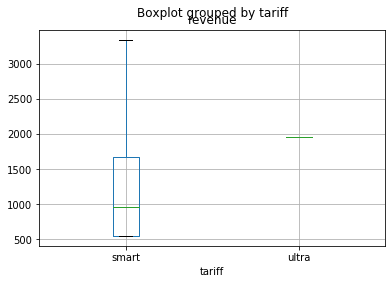

In [39]:
total_users.boxplot(by='tariff', column='revenue', showfliers=False)

Средний доход от тарифа `smart` меньше дохода от тарифа `ultra`, но датасет скошен вправо. На тарифе `smart` пользователи платят существенно больше средней стоимости.
75% пользователей тарифа `smart` платят до 1668 р, что меньше среднего дохода от тарифа `ultra`.

### Вывод

При тарифе `smart` пользователям, в среднем, не хватает объема интернет-трафика. Средняя выручка больше стандартной - 960р.
Средняя выручка тарифа `ultra` в 2 раза больше, чем средняя выручка тарифа `smart`. Большинству пользователей тарифа `ultra` хватает стандартного пакета.

### 4. Проверка гипотез

#### 4.1 Cредняя выручка пользователей тарифов `smart` и `ultra` различается

Для проверки этой гипотезы будем использовать гипотезу о равенстве средних

Нулевая гипотеза - средняя выручка пользователей тарифов `smart` и `ultra` не различается.  
Альтернативная гипотеза - средняя выручка пользователей тарифов `smart` и `ultra` различается.

In [40]:
from scipy import stats as st 
 
rev_smart = total_users[total_users['tariff'] == 'smart']['revenue'].values 
rev_ultra = total_users[total_users['tariff'] == 'ultra']['revenue'].values
 
results = st.ttest_ind(rev_smart, rev_ultra) 
 
print('p-значение: ', results.pvalue) 

p-значение:  1.1725472632486433e-190


Вероятность показывает, что такое или большее отличие можно получить случайно. В данном случае p-значение существенно ниже порогового значения (5%).  
Гипотезу о равенстве средних отвергаем. Cредняя выручка пользователей тарифов различается.

#### 4.2 Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Рассмотрим по тарифу `smart`.

Нулевая гипотеза - равенство средней выручки в Москве и других городах.  
Альтернативная гипотеза - средняя выручка в Москве и других городах различна.

In [41]:
rev_smart_moscow = total_users[(total_users['tariff'] == 'smart') & (total_users['city'] == 'Москва')]['revenue'].values
rev_smart_cities = total_users[(total_users['tariff'] == 'smart') & ~(total_users['city'] == 'Москва')]['revenue'].values

results_smart = st.ttest_ind(rev_smart_moscow, rev_smart_cities) 
 
print('p-значение: ', results_smart.pvalue)

p-значение:  0.1671212202755376


С вероятностью 17% такие или большие различия можно получить случайно. Нулевую гипотезу отвергнуть не можем.  
Различия средней выручки пользователей не статистически значимые.

Рассмотрим по тарифу `ultra`.

Нулевая гипотеза - равенство средней выручки в Москве и других городах.  
Альтернативная гипотеза - средняя выручка в Москве и других городах различна.

In [42]:
rev_ultra_moscow = total_users[(total_users['tariff'] == 'ultra') & (total_users['city'] == 'Москва')]['revenue'].values
rev_ultra_cities = total_users[(total_users['tariff'] == 'ultra') & ~(total_users['city'] == 'Москва')]['revenue'].values

results_ultra = st.ttest_ind(rev_ultra_moscow, rev_ultra_cities) 
 
print('p-значение: ', results_ultra.pvalue)

p-значение:  0.8820693695640969


С вероятностью 88% такие или большие различия можно получить случайно. Нулевую гипотезу отвергнуть не можем.
Различия средней выручки пользователей не статистически значимые.

### Вывод

Средняя выручка по тарифам различна.  
Средняя выручка пользователей из Москвы статистически значимо не отличается от выручки пользователей из других регионов.

### 5. Общий вывод

Больше пользователей выбирают тариф `smart` и итоговая выручка с этого тарифа привышает выручку с тарифа `ultra`. Но выгоднее будет иметь больше пользователей на тарифе `ultra` из-за разницы в средней выручке с 1 пользователя.  

Средняя выручка по тарифам различна. 
Средняя выручка тарифа `smart` больше стандартной - 960 р. Средняя выручка тарифа `ultra` в 2 раза больше - 1950 р. (стандартная плата за этот тариф).  
При этом средняя выручка пользователей из Москвы статистически значимо не отличается от выручки пользователей из других регионов.    
Не смотря на то, что в итоге многие пользователи тарифа `smart` платят намного больше стандартной стоимости тарифа, 75% пользователей все равно платят не больше 1668 р.